# step1 - dataset download

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'stanford-cars-dataset' dataset.
Path to dataset files: /kaggle/input/stanford-cars-dataset


In [4]:
import os

base_path = "/kaggle/input/stanford-cars-dataset"
os.listdir(base_path)


['cars_test', 'car_devkit', 'cars_train']

# step2 - Dataset Preparation

In [5]:
import os
import scipy.io as sio
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cars_train_path = "/kaggle/input/stanford-cars-dataset/cars_train/cars_train"
annos_path = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat"
meta_path  = "/kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_meta.mat"

#Load MAT files
annos = sio.loadmat(annos_path)
meta  = sio.loadmat(meta_path)

annotations = annos["annotations"][0]
class_names = meta["class_names"][0]

print("Annotations:", len(annotations))
print("Classes:", len(class_names))

#Build DataFrame
rows = []

for a in annotations:
    img_name = a["fname"].item()
    class_id = int(a["class"].item()) - 1
    label    = class_names[class_id][0]

    img_path = os.path.join(cars_train_path, img_name)

    if os.path.exists(img_path):
        rows.append([img_path, label])

df = pd.DataFrame(rows, columns=["filename", "class"])

print("Total images:", len(df))
print("Unique classes:", df["class"].nunique())


Annotations: 8144
Classes: 196
Total images: 8144
Unique classes: 196


# Split Data into Train & Validation

In [6]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["class"],
    random_state=42
)


In [7]:
selected_classes = train_df['class'].unique()[:10]

train_df_10 = train_df[train_df['class'].isin(selected_classes)].copy()
val_df_10   = val_df[val_df['class'].isin(selected_classes)].copy()

print(train_df_10['class'].nunique(), val_df_10['class'].nunique())


10 10


# Create Image Data Generators

In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load Images Using DataFrame

In [9]:
train_data = train_gen.flow_from_dataframe(
    train_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_data = val_gen.flow_from_dataframe(
    val_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 349 validated image filenames belonging to 10 classes.
Found 88 validated image filenames belonging to 10 classes.


# step3 - Model Building & Training

# ResNet50

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

NUM_CLASSES = len(train_data.class_indices)

# 1) Load base model
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze pretrained layers
base_model.trainable = False

# 2) Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_resnet = Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print(len(train_data.class_indices))

10


In [12]:
class_indices = train_data.class_indices

for cls, idx in class_indices.items():
    print(idx, ":", cls)


0 : AM General Hummer SUV 2000
1 : Audi 100 Sedan 1994
2 : Audi R8 Coupe 2012
3 : Chrysler Crossfire Convertible 2008
4 : Ford Focus Sedan 2007
5 : GMC Terrain SUV 2012
6 : Hyundai Tucson SUV 2012
7 : Jeep Wrangler SUV 2012
8 : Lamborghini Diablo Coupe 2001
9 : Volvo 240 Sedan 1993


# model compile

In [13]:
model_resnet.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# model training

In [14]:
history_resnet = model_resnet.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 7s/step - accuracy: 0.1852 - loss: 2.5797 - val_accuracy: 0.6705 - val_loss: 1.1160
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - accuracy: 0.5055 - loss: 1.4373 - val_accuracy: 0.7386 - val_loss: 0.8721
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.6651 - loss: 1.0467 - val_accuracy: 0.7500 - val_loss: 0.6917
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.7095 - loss: 0.8335 - val_accuracy: 0.8068 - val_loss: 0.5731
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 110s 10s/step - accuracy: 0.7927 - loss: 0.5985 - val_accuracy: 0.8295 - val_loss: 0.5268
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - accuracy: 0.7956 - loss: 0.5518 - val_accuracy: 0.8182 - val_loss: 0.4880
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.8657 - loss: 0.3907 - val_accuracy: 0.9091 - val_loss: 0.3773
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - accuracy: 0.8546 - loss: 0.4193 - val_accuracy: 0.8182 - val_

# save model

In [15]:
model_resnet.save("resnet50_cars_final.keras")


# plots

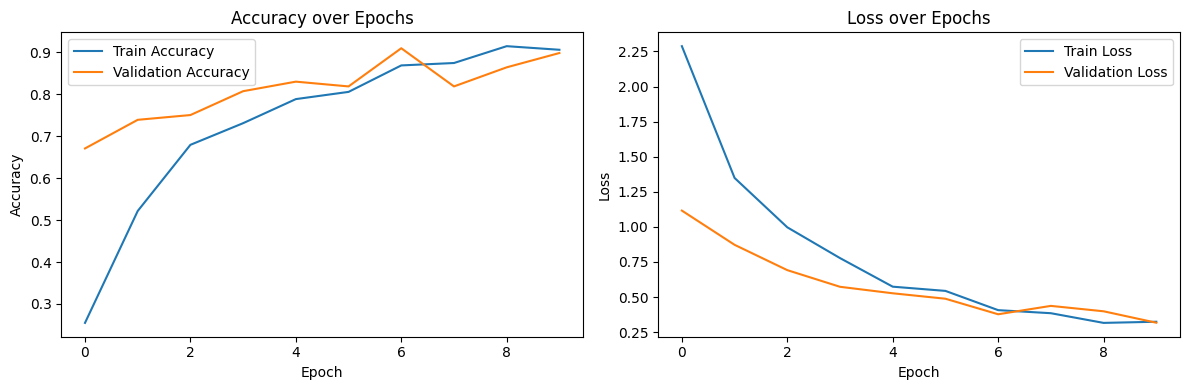

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_resnet.history["accuracy"], label="Train Accuracy")
plt.plot(history_resnet.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_resnet.history["loss"], label="Train Loss")
plt.plot(history_resnet.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step


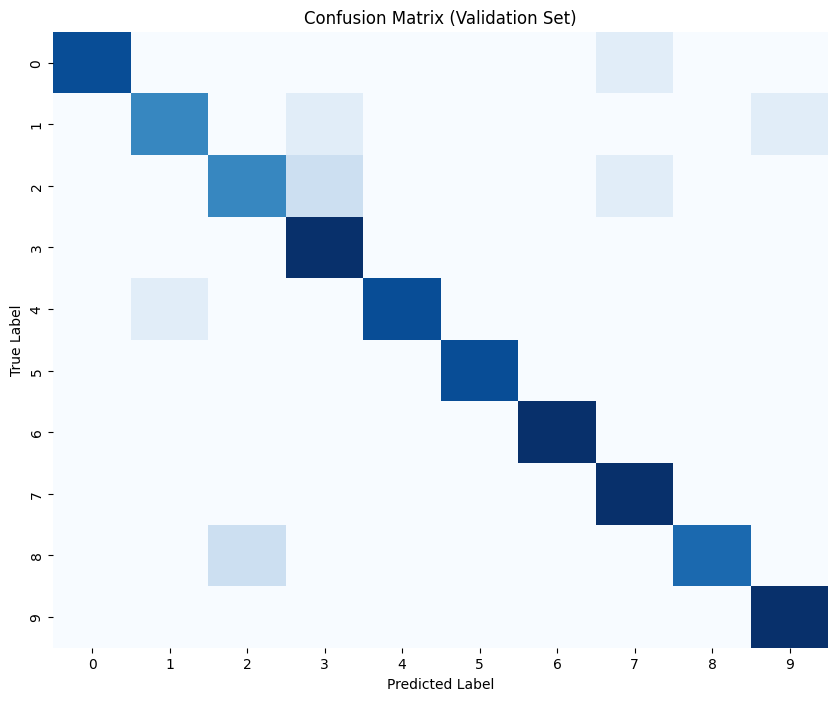

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model_resnet.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# model 2 (EfficientNetB0)

# Image Data Generator

In [19]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


# Data loaders

In [20]:
train_data_eff = train_gen_eff.flow_from_dataframe(
    train_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_data_eff = val_gen_eff.flow_from_dataframe(
    val_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 349 validated image filenames belonging to 10 classes.
Found 88 validated image filenames belonging to 10 classes.


# build model

In [21]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

NUM_CLASSES = len(train_data_eff.class_indices)

base_eff = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_eff.trainable = False

x = base_eff.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_eff = Model(base_eff.input, output)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# compile


In [22]:
import tensorflow as tf

model_eff.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# train

In [23]:
history_eff = model_eff.fit(
    train_data_eff,
    validation_data=val_data_eff,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.2492 - loss: 2.0966 - val_accuracy: 0.7386 - val_loss: 1.2292
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6940 - loss: 1.1270 - val_accuracy: 0.7841 - val_loss: 0.7964
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8272 - loss: 0.6399 - val_accuracy: 0.8409 - val_loss: 0.5688
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8451 - loss: 0.5334 - val_accuracy: 0.8523 - val_loss: 0.5432
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8679 - loss: 0.4327 - val_accuracy: 0.8409 - val_loss: 0.4674
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9181 - loss: 0.2958 - val_accuracy: 0.8864 - val_loss: 0.4111
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9142 - loss: 0.2784 - val_accuracy: 0.8636 - val_loss: 0.4239
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9457 - loss: 0.2412 - val_accuracy: 0.8864 - val_loss:

# save model

In [24]:
model_eff.save("efficientnet_10classes_final.keras")


# plots

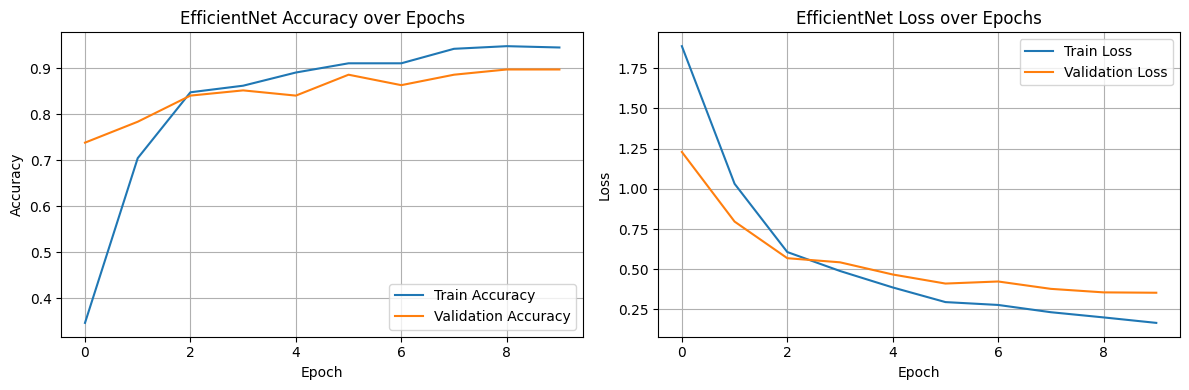

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_eff.history["accuracy"], label="Train Accuracy")
plt.plot(history_eff.history["val_accuracy"], label="Validation Accuracy")
plt.title("EfficientNet Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_eff.history["loss"], label="Train Loss")
plt.plot(history_eff.history["val_loss"], label="Validation Loss")
plt.title("EfficientNet Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Confusion Matrix

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


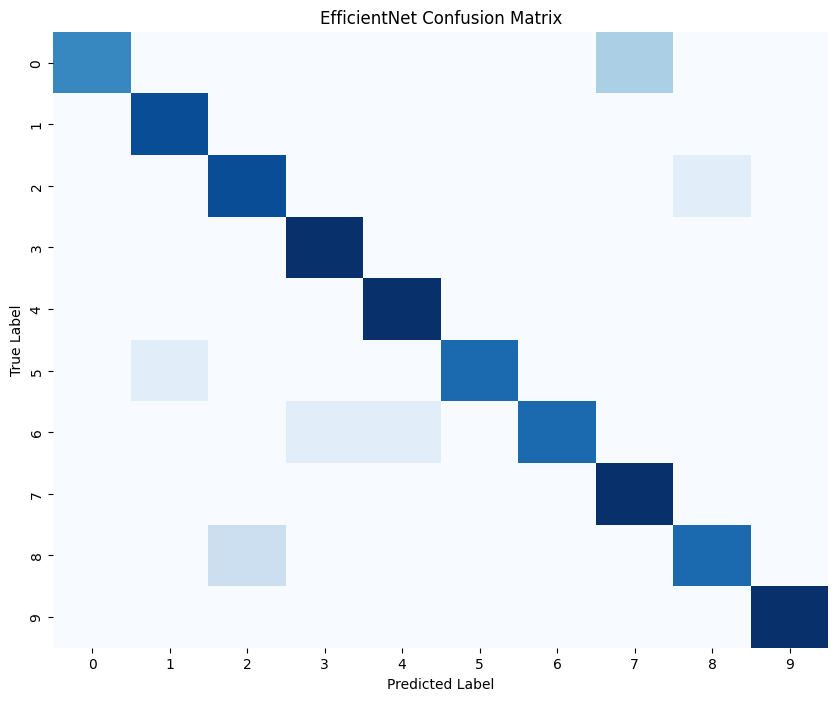

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Reset generator
val_data_eff.reset()

# Predictions
y_pred = model_eff.predict(val_data_eff)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = val_data_eff.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("EfficientNet Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# model 3 (MobileNetV2)

# Image Data Generator

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

train_gen_mob = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen_mob = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


# Load Data

In [28]:
train_data_mob = train_gen_mob.flow_from_dataframe(
    train_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

val_data_mob = val_gen_mob.flow_from_dataframe(
    val_df_10,
    x_col="filename",
    y_col="class",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 349 validated image filenames belonging to 10 classes.
Found 88 validated image filenames belonging to 10 classes.


# Build MobileNetV2 Model

In [29]:
base_model_mob = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model_mob.trainable = False

x = base_model_mob.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_mob = Model(inputs=base_model_mob.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# compile


In [30]:
model_mob.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# train

In [31]:
history_mob = model_mob.fit(
    train_data_mob,
    validation_data=val_data_mob,
    epochs=10
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.2197 - loss: 2.4183 - val_accuracy: 0.4545 - val_loss: 1.4292
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5180 - loss: 1.3198 - val_accuracy: 0.5795 - val_loss: 1.0947
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6733 - loss: 1.1095 - val_accuracy: 0.7386 - val_loss: 0.9126
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7780 - loss: 0.7355 - val_accuracy: 0.7500 - val_loss: 0.7838
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7940 - loss: 0.6103 - val_accuracy: 0.7841 - val_loss: 0.7266
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8064 - loss: 0.5808 - val_accuracy: 0.7841 - val_loss: 0.7210
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8737 - loss: 0.4327 - val_accuracy: 0.8523 - val_loss: 0.6221
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8352 - loss: 0.4705 - val_accuracy: 0.7614 - val_loss:

# save model

In [32]:
model_mob.save("mobilenetv2_10classes_final.keras")


# plots

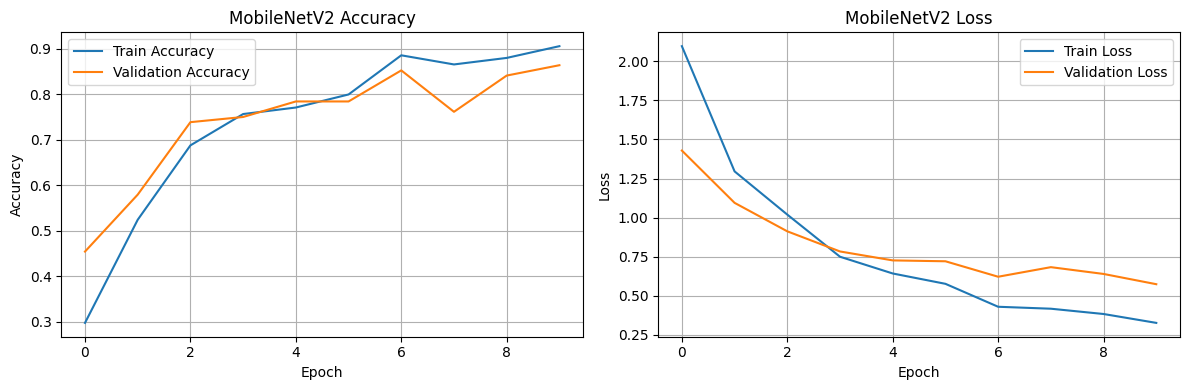

In [33]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_mob.history["accuracy"], label="Train Accuracy")
plt.plot(history_mob.history["val_accuracy"], label="Validation Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_mob.history["loss"], label="Train Loss")
plt.plot(history_mob.history["val_loss"], label="Validation Loss")
plt.title("MobileNetV2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Confusion Matrix

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


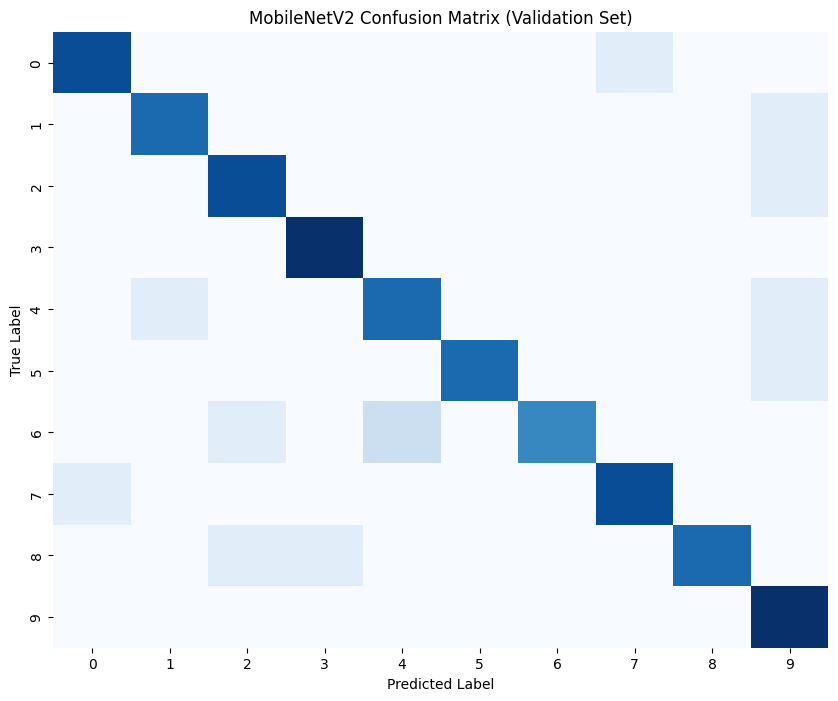

In [34]:
val_data_mob.reset()

y_pred = model_mob.predict(val_data_mob)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data_mob.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("MobileNetV2 Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Comparison Plots (ResNet50 – EfficientNet – MobileNetV2)

# Accuracy Comparison (Train)

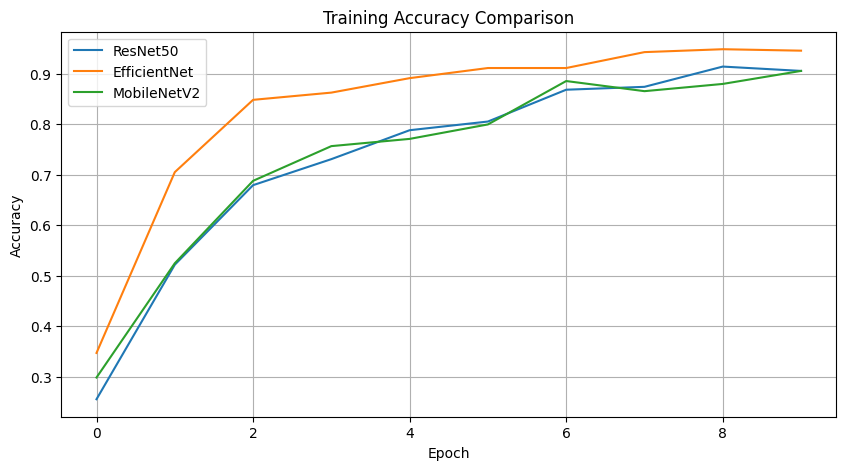

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(history_resnet.history["accuracy"], label="ResNet50")
plt.plot(history_eff.history["accuracy"], label="EfficientNet")
plt.plot(history_mob.history["accuracy"], label="MobileNetV2")

plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Validation Accuracy Comparison

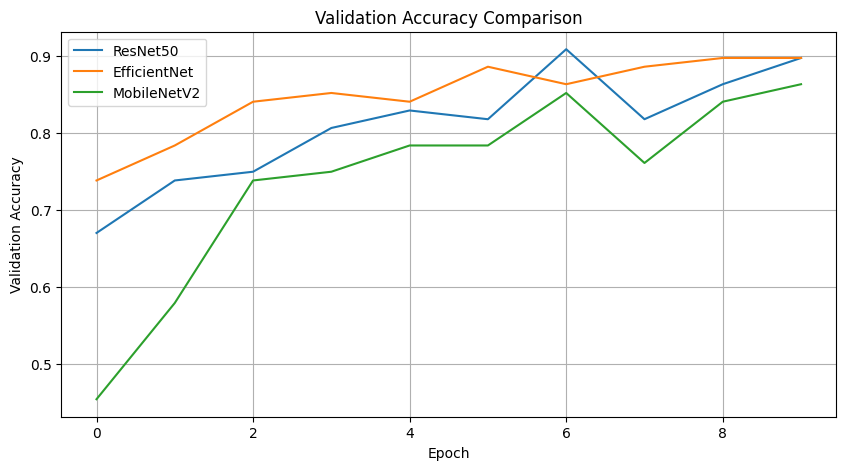

In [36]:
plt.figure(figsize=(10,5))

plt.plot(history_resnet.history["val_accuracy"], label="ResNet50")
plt.plot(history_eff.history["val_accuracy"], label="EfficientNet")
plt.plot(history_mob.history["val_accuracy"], label="MobileNetV2")

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# Loss Comparison (Train)

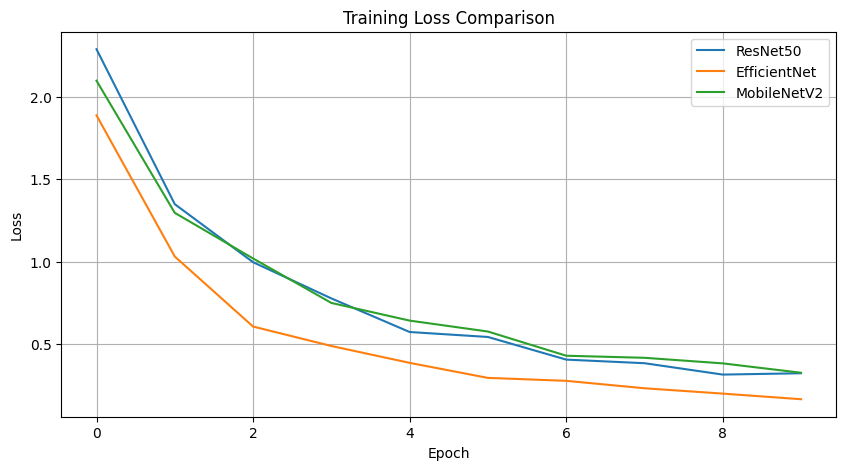

In [37]:
plt.figure(figsize=(10,5))

plt.plot(history_resnet.history["loss"], label="ResNet50")
plt.plot(history_eff.history["loss"], label="EfficientNet")
plt.plot(history_mob.history["loss"], label="MobileNetV2")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Validation Loss Comparison

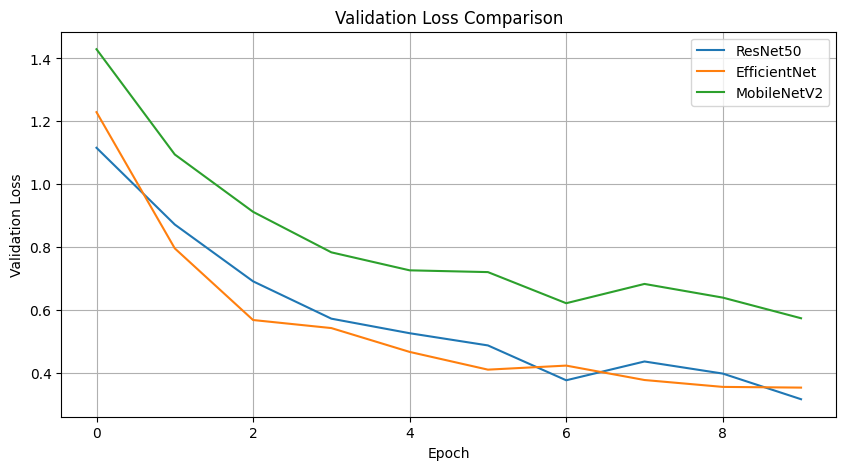

In [38]:
plt.figure(figsize=(10,5))

plt.plot(history_resnet.history["val_loss"], label="ResNet50")
plt.plot(history_eff.history["val_loss"], label="EfficientNet")
plt.plot(history_mob.history["val_loss"], label="MobileNetV2")

plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# GUI

In [28]:
import os, shutil
import scipy.io as sio

# PATHS (KAGGLE)

BASE_PATH = "/kaggle/input/stanford-cars-dataset"

IMAGES_PATH = os.path.join(BASE_PATH, "cars_train", "cars_train")
ANNOS_PATH  = os.path.join(BASE_PATH, "car_devkit", "devkit", "cars_train_annos.mat")
META_PATH   = os.path.join(BASE_PATH, "car_devkit", "devkit", "cars_meta.mat")

DEST_BASE = "/kaggle/working/sample_images"


# TARGET CLASSES (by NAME)
TARGET_CLASSES = {
    "AM General Hummer SUV 2000": "AM_General_Hummer_SUV_2000",
    "Audi 100 Sedan 1994": "Audi_100_Sedan_1994",
    "Audi R8 Coupe 2012": "Audi_R8_Coupe_2012",
    "Chrysler Crossfire Convertible 2008": "Chrysler_Crossfire_Convertible_2008",
    "Ford Focus Sedan 2007": "Ford_Focus_Sedan_2007",
    "GMC Terrain SUV 2012": "GMC_Terrain_SUV_2012",
    "Hyundai Tucson SUV 2012": "Hyundai_Tucson_SUV_2012",
    "Jeep Wrangler SUV 2012": "Jeep_Wrangler_SUV_2012",
    "Lamborghini Diablo Coupe 2001": "Lamborghini_Diablo_Coupe_2001",
    "Volvo 240 Sedan 1993": "Volvo_240_Sedan_1993",
}


# LOAD MAT FILES
annos = sio.loadmat(ANNOS_PATH)["annotations"][0]
meta  = sio.loadmat(META_PATH)["class_names"][0]

id_to_name = {
    i + 1: meta[i][0]
    for i in range(len(meta))
}

os.makedirs(DEST_BASE, exist_ok=True)
count = {k: 0 for k in TARGET_CLASSES}

for a in annos:
    class_id = int(a["class"][0][0])
    class_name = id_to_name[class_id]
    img_name = a["fname"][0]

    if class_name not in TARGET_CLASSES:
        continue

    src_img = os.path.join(IMAGES_PATH, img_name)
    dst_dir = os.path.join(DEST_BASE, TARGET_CLASSES[class_name])
    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(src_img):
        shutil.copy(src_img, os.path.join(dst_dir, img_name))
        count[class_name] += 1
print(" Images copied successfully:\n")
for k, v in count.items():
    print(f"{k}: {v} images")


✅ Images copied successfully:

AM General Hummer SUV 2000: 45 images
Audi 100 Sedan 1994: 41 images
Audi R8 Coupe 2012: 43 images
Chrysler Crossfire Convertible 2008: 43 images
Ford Focus Sedan 2007: 45 images
GMC Terrain SUV 2012: 42 images
Hyundai Tucson SUV 2012: 44 images
Jeep Wrangler SUV 2012: 43 images
Lamborghini Diablo Coupe 2001: 45 images
Volvo 240 Sedan 1993: 46 images


In [31]:
import gradio as gr
import numpy as np
import tensorflow as tf
import cv2, os, random
from PIL import Image

BASE_IMAGES = "/kaggle/working/sample_images"


CLASS_FOLDERS = {
    "AM General Hummer SUV 2000": "AM_General_Hummer_SUV_2000",
    "Audi 100 Sedan 1994": "Audi_100_Sedan_1994",
    "Audi R8 Coupe 2012": "Audi_R8_Coupe_2012",
    "Chrysler Crossfire Convertible 2008": "Chrysler_Crossfire_Convertible_2008",
    "Ford Focus Sedan 2007": "Ford_Focus_Sedan_2007",
    "GMC Terrain SUV 2012": "GMC_Terrain_SUV_2012",
    "Hyundai Tucson SUV 2012": "Hyundai_Tucson_SUV_2012",
    "Jeep Wrangler SUV 2012": "Jeep_Wrangler_SUV_2012",
    "Lamborghini Diablo Coupe 2001": "Lamborghini_Diablo_Coupe_2001",
    "Volvo 240 Sedan 1993": "Volvo_240_Sedan_1993",
}

CLASS_NAMES = list(CLASS_FOLDERS.keys())


# LOAD MODELS
MODELS = {
    "ResNet50": {
        "model": tf.keras.models.load_model("resnet50_cars_final.keras"),
        "preprocess": tf.keras.applications.resnet50.preprocess_input,
        "last_conv": "conv5_block3_out"
    },
    "EfficientNet": {
        "model": tf.keras.models.load_model("efficientnet_10classes_final.keras"),
        "preprocess": tf.keras.applications.efficientnet.preprocess_input,
        "last_conv": "top_conv"
    },
    "MobileNetV2": {
        "model": tf.keras.models.load_model("mobilenetv2_10classes_final.keras"),
        "preprocess": tf.keras.applications.mobilenet_v2.preprocess_input,
        "last_conv": "Conv_1"
    }
}

# GRAD-CAM
def gradcam(model, last_conv, img_array, class_idx):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = conv_out[0] @ pooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()


# PREDICTION
def predict(img, model_name):
    cfg = MODELS[model_name]
    model = cfg["model"]

    img_resized = img.resize((224,224))
    x = np.expand_dims(np.array(img_resized), axis=0)
    x = cfg["preprocess"](x)

    preds = model.predict(x)[0]
    top3 = np.argsort(preds)[-3:][::-1]

    result_text = ""
    for i, idx in enumerate(top3):
        result_text += f"{i+1}. {CLASS_NAMES[idx]} — {preds[idx]*100:.2f}%\n"

    heatmap = gradcam(model, cfg["last_conv"], x, top3[0])
    heatmap = cv2.resize(heatmap, img.size)
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

    return result_text, Image.fromarray(overlay)

# LOAD RANDOM IMAGE
def load_random_image():
    items = []
    for class_name, folder in CLASS_FOLDERS.items():
        folder_path = os.path.join(BASE_IMAGES, folder)
        if os.path.exists(folder_path):
            for img in os.listdir(folder_path):
                if img.lower().endswith((".jpg", ".jpeg", ".png")):
                    items.append((class_name, os.path.join(folder_path, img)))

    true_class, img_path = random.choice(items)
    img = Image.open(img_path).convert("RGB")

    return img, f"**True Class:** {true_class}"

# GUI
with gr.Blocks(css="""
#main {max-width: 100%;}
.gradio-container {width: 100vw;}
""") as demo:

    gr.Markdown(
        "##Car Classification with Grad-CAM\n"
        "**Random Image | Ground Truth | 3 Models | Explainable AI**"
    )

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="Car Image", height=420)

            true_label = gr.Markdown("**True Class:** —")

            random_btn = gr.Button(" Load Random Image (10 Classes)")
            model_choice = gr.Dropdown(
                choices=list(MODELS.keys()),
                value="ResNet50",
                label="Choose Model"
            )

            predict_btn = gr.Button("Run Prediction", variant="primary")

        with gr.Column(scale=1):
            preds_out = gr.Textbox(label="Top-3 Predictions", lines=6)
            gradcam_out = gr.Image(label="Grad-CAM Visualization", height=420)

    random_btn.click(load_random_image, outputs=[image_input, true_label])
    predict_btn.click(
        predict,
        inputs=[image_input, model_choice],
        outputs=[preds_out, gradcam_out]
    )

demo.launch()


/tmp/ipython-input-355151071.py:102: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css="""


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ebee82a2cb4913265c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
